In [27]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.1
1.4.1


In [28]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes

In [29]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_id', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'm4_weekly_domain', 'm4_weekly_id', 'my_wee

In [31]:
dataname = "m4_daily_id"
dataset = get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_daily_id.


In [32]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])


In [33]:
train_entry

{'start': Timestamp('1750-01-01 00:00:00', freq='D'),
 'item_id': 'D1',
 'target': array([1017.1, 1019.3, 1017. , ..., 2022.1, 2031.6, 2029.7], dtype=float32),
 'feat_static_cat': array([1]),
 'source': SourceContext(source=Span(path=WindowsPath('C:/Users/TM/.mxnet/gluon-ts/datasets/m4_daily_id/train/m4_daily_id_train.json'), line=1), row=1)}

In [34]:
dataset.metadata.feat_static_cat

[<CategoricalFeatureInfo name='feat_static_cat' cardinality='4227'>]

In [35]:
[feat_static_cat.cardinality for feat_static_cat in dataset.metadata.feat_static_cat]

['4227']

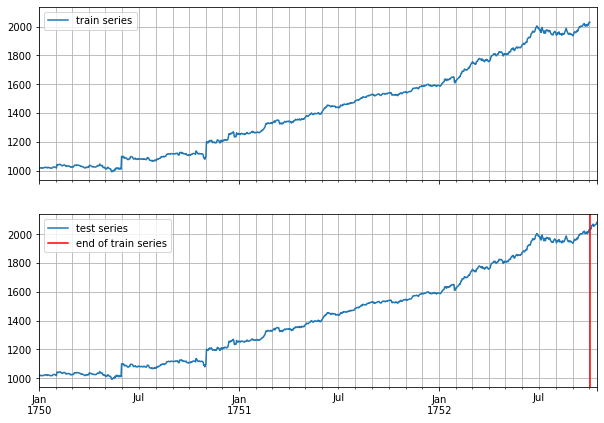

In [36]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [37]:
# gluonts
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

# DeepAREstimator
from gluonts.model.deepar import DeepAREstimator

In [38]:
print(dataname)
epochs=500
num_batches = 100

mx.random.seed(42)
np.random.seed(42)

trainer = Trainer(
    ctx=mx.cpu(0),
    epochs=epochs,
    num_batches_per_epoch=num_batches,
    learning_rate=1e-3,
)

estimator = DeepAREstimator(
    trainer=trainer,
    cardinality= [
        feat_static_cat.cardinality 
        for feat_static_cat in dataset.metadata.feat_static_cat
    ],
#     context_length=dataset.metadata.prediction_length,
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True
)

predictor = estimator.train(training_data=dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
    dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

m4_daily_id


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:33<00:00,  2.95it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[0] Elapsed time 33.934 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.226948
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:34<00:00,  2.90it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[1] Elapsed time 34.507 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.493837
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.96it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[2] Elapsed time 9.127 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.460313
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.23it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[3] Elapsed time 8.917 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.351659
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.12it/s, avg

INFO:root:Epoch[36] Elapsed time 9.267 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.531569
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.37it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[37] Elapsed time 11.944 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.587808
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.64it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[38] Elapsed time 9.420 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.623834
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.71it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[39] Elapsed time 9.339 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.583794
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 11.02it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[40] Elapsed time 9.076 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.524466
INFO:roo

INFO:root:Epoch[73] Elapsed time 9.399 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.422895
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.38it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[74] Elapsed time 9.644 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.438927
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.77it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[75] Elapsed time 9.293 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.409750
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.43it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[76] Elapsed time 9.593 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.473681
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 11.09it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[77] Elapsed time 9.024 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.415797
INFO:root

INFO:root:Epoch[109] Elapsed time 9.341 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.419167
INFO:root:Epoch[110] Learning rate is 0.000125
100%|██████████| 100/100 [00:09<00:00, 10.86it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[110] Elapsed time 9.209 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.423596
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:09<00:00, 10.51it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[111] Elapsed time 9.518 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.369338
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:09<00:00, 10.77it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[112] Elapsed time 9.287 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.367360
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:09<00:00, 10.28it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[113] Elapsed time 9.730 seconds
INFO:root:Epoch[113] Evaluation metric 'epoc

100%|██████████| 100/100 [00:10<00:00,  9.35it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[145] Elapsed time 10.695 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=5.403900
INFO:root:Epoch[146] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:10<00:00,  9.78it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[146] Elapsed time 10.229 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.430545
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:09<00:00, 11.01it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[147] Elapsed time 9.098 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.382015
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:09<00:00, 10.64it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[148] Elapsed time 9.399 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.337787
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:09<00:00, 10.64it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[149] 

100%|██████████| 100/100 [00:09<00:00, 10.62it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[181] Elapsed time 9.412 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=5.315022
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:09<00:00, 11.02it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[182] Elapsed time 9.094 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.383353
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:12<00:00,  8.31it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[183] Elapsed time 12.038 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.432570
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  9.01it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[184] Elapsed time 11.097 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.355615
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.87it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[185] Elapsed ti

INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=5.377688
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:09<00:00, 10.93it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[218] Elapsed time 9.150 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=5.360447
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:09<00:00, 10.93it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[219] Elapsed time 9.163 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.380072
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:09<00:00, 10.39it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[220] Elapsed time 9.629 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.413600
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  9.09it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[221] Elapsed time 11.004 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.319390
INFO:root:Epoch[222] Learning rate is 5e-0

100%|██████████| 100/100 [00:08<00:00, 11.12it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[254] Elapsed time 9.006 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=5.373578
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:09<00:00, 10.95it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[255] Elapsed time 9.155 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=5.337968
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:09<00:00, 10.78it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[256] Elapsed time 9.277 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.346075
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:09<00:00, 10.89it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[257] Elapsed time 9.202 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.417172
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:08<00:00, 11.15it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[258] Elapsed time

INFO:root:Epoch[290] Elapsed time 10.343 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=5.381330
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.60it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[291] Elapsed time 10.424 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=5.389019
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.27it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[292] Elapsed time 10.800 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=5.360509
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.39it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[293] Elapsed time 11.939 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.359524
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.12it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[294] Elapsed time 10.963 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'

INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=5.360609
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.99it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[327] Elapsed time 10.035 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=5.364721
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.78it/s, avg_epoch_loss=5.35]
INFO:root:Epoch[328] Elapsed time 10.247 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=5.350082
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:10<00:00,  9.63it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[329] Elapsed time 10.398 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.326881
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:12<00:00,  8.20it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[330] Elapsed time 12.201 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.344103
INFO:root:Epoch[331] Learning rate is 5

INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:20<00:00,  4.97it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[363] Elapsed time 20.112 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=5.420617
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:14<00:00,  6.84it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[364] Elapsed time 14.623 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=5.386507
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:14<00:00,  6.84it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[365] Elapsed time 14.631 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=5.389331
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:15<00:00,  6.36it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[366] Elapsed time 15.723 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.320576
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:19<00:00,  5.01it/s, avg_ep

100%|██████████| 100/100 [00:15<00:00,  6.25it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[399] Elapsed time 15.995 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=5.371165
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:16<00:00,  5.89it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[400] Elapsed time 16.992 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=5.405604
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:21<00:00,  4.64it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[401] Elapsed time 21.543 seconds
INFO:root:Epoch[401] Evaluation metric 'epoch_loss'=5.325171
INFO:root:Epoch[402] Learning rate is 5e-05
100%|██████████| 100/100 [00:22<00:00,  4.50it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[402] Elapsed time 22.215 seconds
INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=5.367267
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:21<00:00,  4.62it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[403] Elapsed 

INFO:root:Epoch[435] Elapsed time 14.299 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=5.333667
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:14<00:00,  6.84it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[436] Elapsed time 14.637 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=5.322144
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:16<00:00,  6.01it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[437] Elapsed time 16.629 seconds
INFO:root:Epoch[437] Evaluation metric 'epoch_loss'=5.410437
INFO:root:Epoch[438] Learning rate is 5e-05
100%|██████████| 100/100 [00:15<00:00,  6.47it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[438] Elapsed time 15.465 seconds
INFO:root:Epoch[438] Evaluation metric 'epoch_loss'=5.379460
INFO:root:Epoch[439] Learning rate is 5e-05
100%|██████████| 100/100 [00:14<00:00,  6.93it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[439] Elapsed time 14.430 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'

INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=5.370793
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:14<00:00,  6.92it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[472] Elapsed time 14.475 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=5.331101
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:14<00:00,  7.08it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[473] Elapsed time 14.145 seconds
INFO:root:Epoch[473] Evaluation metric 'epoch_loss'=5.365286
INFO:root:Epoch[474] Learning rate is 5e-05
100%|██████████| 100/100 [00:14<00:00,  6.99it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[474] Elapsed time 14.327 seconds
INFO:root:Epoch[474] Evaluation metric 'epoch_loss'=5.386591
INFO:root:Epoch[475] Learning rate is 5e-05
100%|██████████| 100/100 [00:15<00:00,  6.44it/s, avg_epoch_loss=5.32]
INFO:root:Epoch[475] Elapsed time 15.554 seconds
INFO:root:Epoch[475] Evaluation metric 'epoch_loss'=5.319932
INFO:root:Epoch[476] Learning rate is 5

In [39]:
metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

pd.DataFrame([output])

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9]
0,3.255229,0.031501,38.089763,0.027818,0.012675


In [40]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,sMAPE,MSIS,QuantileLoss[0.1],...,QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.6],Coverage[0.6],QuantileLoss[0.7],Coverage[0.7],QuantileLoss[0.8],Coverage[0.8],QuantileLoss[0.9],Coverage[0.9]
0,D1,72.399187,83.629395,28864.203125,2061.728795,4.446966,1.343282,0.002904,11.584378,88.114575,...,83.629395,0.285714,85.745898,0.571429,101.816821,0.642857,77.983643,0.857143,56.128369,1.000000
1,D2,2763.325056,560.502686,41976.296875,2998.306920,14.608158,2.740654,0.013378,11.247035,337.867285,...,560.502686,0.000000,441.435352,0.214286,321.773779,0.428571,234.425391,0.785714,122.168408,1.000000
2,D3,1053.357282,412.191162,15435.000000,1102.500000,5.762793,5.109020,0.026377,15.574508,53.872363,...,412.191162,1.000000,403.697461,1.000000,375.510425,1.000000,318.650146,1.000000,197.435083,1.000000
3,D4,32324.232143,2382.399658,15750.000000,1125.000000,42.404762,4.013026,0.148020,36.084002,977.885229,...,2382.399780,0.785714,2154.599609,0.785714,1810.844409,0.785714,1362.687158,0.785714,733.513135,0.857143
4,D5,4886.767299,1039.127930,84076.921875,6005.494420,44.977936,1.650219,0.012384,11.177663,859.477441,...,1039.127930,0.000000,455.415820,0.214286,332.089746,1.000000,569.702539,1.000000,548.217578,1.000000


In [41]:
item_metrics.to_csv("m4_daily_deepar_metrics_owa1014.csv")